In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3195789 sha256=380fc8757dcc12e502726b9088dbe21e7ce2ed3c35fc3aa869de1d76af477b35
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


# Movie Recommendation system

In this Project Hybrid Recommender System is Created using  Collaborative and Content Based
Recommender System


In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

---

# EDA

In [ ]:
#Reading the Input files
df_ratings_all = pd.read_csv('/content/drive/MyDrive/AIWR/ratings.csv', usecols = ['userId','movieId', 'rating'])
df_ratings = df_ratings_all.sample(n=1000000)# taking randomly  1000000 enteries for ease of computation
df_ratings.head()

,userId,movieId,rating
17541514,182019,2683,3.0
19666097,204299,2706,3.5
25421015,264700,2571,5.0
5302117,54704,585,4.0
6624852,68367,779,3.0


In [ ]:
na_values = sum(df_ratings.isnull().any())
duplicates = sum(df_ratings.duplicated())
print("duplicated data",duplicates,"missing data",na_values)
print("data types of each column",df_ratings.dtypes)

duplicated data 0 missing data 0
data types of each column userId       int64
movieId      int64
rating     float64
dtype: object


### No na values or duplicates found

In [ ]:
df_ratings.describe()

,userId,movieId,rating
count,1000000.000000,1000000.000000,1000000.000000
mean,135210.472000,15826.996681,3.529176
std,78194.586044,31099.007394,1.065702
min,1.000000,1.000000,0.500000
25%,67310.000000,1061.000000,3.000000
50%,135500.500000,2580.000000,3.500000
75%,202988.000000,6454.000000,4.000000
max,270896.000000,176269.000000,5.000000


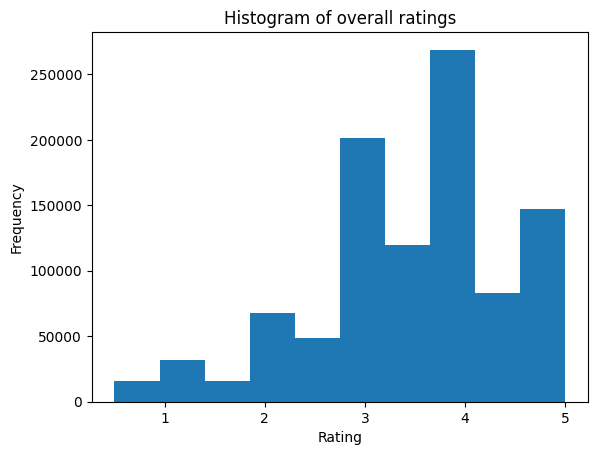

In [ ]:
# Assuming your dataframe is named df_ratings
df_ratings['rating'].plot.hist()

# Set axis labels and title
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of overall ratings')
plt.show()

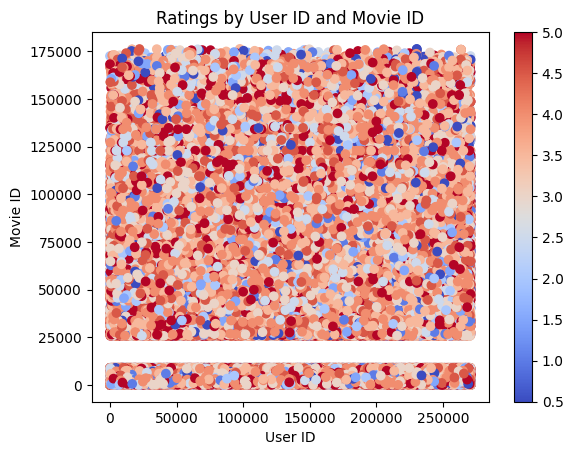

In [ ]:
plt.scatter(df_ratings['userId'], df_ratings['movieId'], c=df_ratings['rating'], cmap='coolwarm')
plt.colorbar()

# Set axis labels and title
plt.xlabel('User ID')
plt.ylabel('Movie ID')
plt.title('Ratings by User ID and Movie ID')
plt.show()

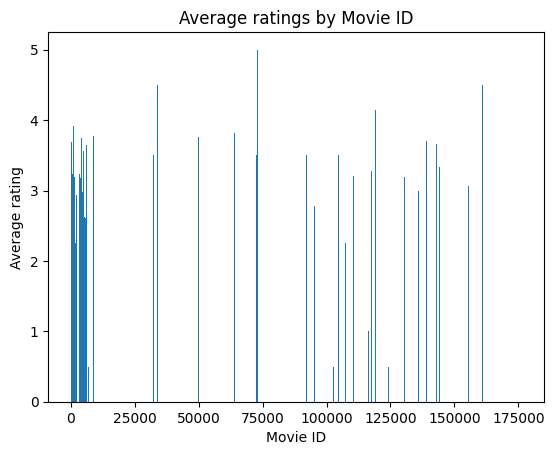

In [ ]:
mean_ratings = df_ratings.groupby('movieId')['rating'].mean()
plt.bar(mean_ratings.index, mean_ratings.values)

# Set axis labels and title
plt.xlabel('Movie ID')
plt.ylabel('Average rating')
plt.title('Average ratings by Movie ID')
plt.show()

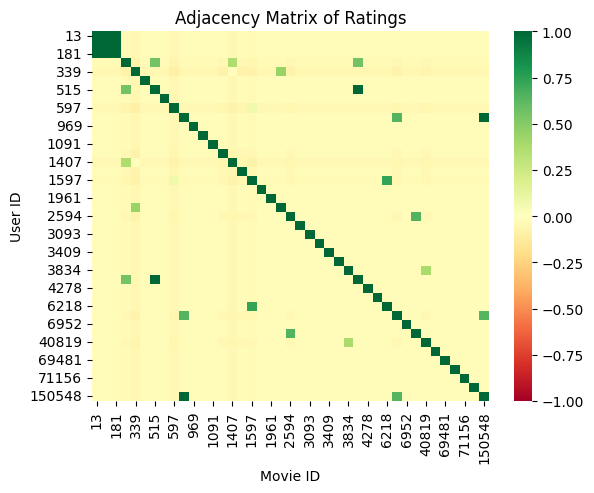

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your data is in a dataframe named df_ratings
# Select a random sample of 500 users and 500 movies
sample_users = np.random.choice(df_ratings['userId'].unique(), size=500, replace=False)
sample_movies = np.random.choice(df_ratings['movieId'].unique(), size=500, replace=False)
df_sample = df_ratings[(df_ratings['userId'].isin(sample_users)) & (df_ratings['movieId'].isin(sample_movies))]

# Create a pivot table with UserIDs as rows and MovieIDs as columns
pivot_table = pd.pivot_table(df_sample, values='rating', index='userId', columns='movieId', fill_value=0)

# Create the adjacency matrix by calculating the correlation between columns
adj_matrix = pivot_table.corr()

# Create the heatmap
sns.heatmap(adj_matrix, cmap='RdYlGn', vmin=-1, vmax=1)

# Set axis labels and title
plt.xlabel('Movie ID')
plt.ylabel('User ID')
plt.title('Adjacency Matrix of Ratings')

plt.show()

---

## Collabrative Filtering



In [ ]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
# Reader is a class in the Surprise library, which is used for reading datasets in a specific format 
reader = Reader(rating_scale=(0.5, 5.0))
#max rating =5 and min rating=0.5
data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)
data

### SVD

In [ ]:
from surprise.model_selection import train_test_split
from surprise import accuracy
trainset, testset = train_test_split(data, test_size=.25)
model=SVD(n_epochs = 10, n_factors = 20)
model.fit(trainset)
predictions = model.test(testset)
accuracy.rmse(predictions)

RMSE: 0.9276


0.9276004343521765

In [ ]:
# Perform cross validation
results = cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9240  0.9223  0.9231  0.9253  0.9229  0.9235  0.0010  
Fit time          6.09    6.13    6.46    6.66    6.95    6.46    0.32    
Test time         1.48    2.78    3.04    1.97    3.14    2.48    0.65    


In [ ]:
benchmark=[]
# Get results & append algorithm name
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series([str(SVD(n_epochs = 10, n_factors = 20)).split(' ')[0].split('.')[-1]]))
benchmark.append(tmp)
print(benchmark)

[test_rmse    0.923517
fit_time     6.458479
test_time    2.482845
0                 SVD
dtype: object]


<ipython-input-56-50dd14b2d82c>:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(SVD(n_epochs = 10, n_factors = 20)).split(' ')[0].split('.')[-1]]))


### Co-Clustering

In [ ]:
from surprise import CoClustering

algocc = CoClustering(n_cltr_u=3, n_cltr_i=3, n_epochs=20, verbose=True)

# Train the algorithm on the trainset
algocc.fit(trainset)

# Evaluate the model on the testset
predictions = algocc.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f'RMSE: {rmse:.4f}, MAE: {mae:.4f}')

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
RMSE: 1.0330
MAE:  0.7957
RMSE: 1.0330, MAE: 0.7957


### SVD++

In [ ]:
from surprise import SVDpp

# Define the SVD++ algorithm with hyperparameters
algo = SVDpp(n_factors=50, lr_all=0.005, reg_all=0.02)

# Train the algorithm on the trainset
algo.fit(trainset)

# Evaluate the model on the testset
predictions = algo.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f'RMSE: {rmse:.4f}, MAE: {mae:.4f}')

RMSE: 0.9255
MAE:  0.7141
RMSE: 0.9255, MAE: 0.7141


## SVD model is made to fit on training dataset

In [ ]:
def get_collabration_based_recommendations(userId, movieId):
    return model.predict(userId, movieId).est

In [ ]:
get_collabration_based_recommendations(1, 250) 

2.9363234628311563

* gives estimated rating for a given userid and movie id

---

## Content-based Recommendation

Our criteria will be to recommend movies with same features as directors, cast, genres, keywords etc.


In [ ]:
# Read required files
credits = pd.read_csv('/content/drive/MyDrive/AIWR/credits.csv')
print("Type of credit columns:\n ", credits.dtypes)
movies = pd.read_csv('/content/drive/MyDrive/AIWR/movies_metadata.csv')
print("Type of movies columns:\n ", movies.dtypes)
keywords = pd.read_csv('/content/drive/MyDrive/AIWR/keywords.csv')
print("Type of keywords columns:\n ", keywords.dtypes)

Type of credit columns:
  cast    object
crew    object
id       int64
dtype: object


<ipython-input-23-a5831ae30a24>:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv('/content/drive/MyDrive/AIWR/movies_metadata.csv')


Type of movies columns:
  adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object
Type of keywords columns:
  id           int64
keywords    object
dtype: object


In [ ]:
# We will merge these three files to the one dataframe. But id of movie column is object but for other files movie id column is int64.
# Convert these int64 to string then merge
keywords['id'] = keywords['id'].astype('str')
credits['id'] = credits['id'].astype('str')
df_merge = (credits.merge(movies,on='id')).merge(keywords,on='id')
df = df_merge[:10000]
df.dtypes

cast                      object
crew                      object
id                        object
adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
keywords                  object
dtype: object

In [ ]:
df.head()

,cast,crew,id,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,keywords
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,tt0114709,en,...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,tt0113497,en,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,tt0113228,en,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0114885,en,...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt0113041,en,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


## Pre-Processing

In [ ]:
# Choose which columns will be used.
df = df[['title','cast', 'crew', 'genres','keywords','original_language']]
print(sum(df.isnull().any()))

0


* No null values

In [ ]:
df

,title,cast,crew,genres,keywords,original_language
0,Toy Story,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",en
1,Jumanji,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",en
2,Grumpier Old Men,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",en
3,Waiting to Exhale,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 818, 'name': 'based on novel'}, {'id':...",en
4,Father of the Bride Part II,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 35, 'name': 'Comedy'}]","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",en
...,...,...,...,...,...,...
9995,National Lampoon's Gold Diggers,"[{'cast_id': 4, 'character': 'Calvin Menhoffer...","[{'credit_id': '52fe467cc3a36847f81019f9', 'de...","[{'id': 35, 'name': 'Comedy'}]",[],en
9996,Blind Horizon,"[{'cast_id': 1, 'character': 'Frank Kavanaugh'...","[{'credit_id': '59665828c3a36825e8116b9a', 'de...","[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",[],en
9997,Islands in the Stream,"[{'cast_id': 1029, 'character': 'Thomas Hudson...","[{'credit_id': '52fe481ac3a368484e0e94f9', 'de...","[{'id': 18, 'name': 'Drama'}]",[],en
9998,Go for Broke!,"[{'cast_id': 1, 'character': 'Lt. Michael Gray...","[{'credit_id': '52fe46349251416c9104cb19', 'de...","[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...","[{'id': 1956, 'name': 'world war ii'}, {'id': ...",en


In [ ]:
import unicodedata
import re
def clean_data(value):
    value =  unicodedata.normalize('NFD', value).encode('ascii', 'ignore').decode('ascii')
    x = str.lower(re.sub(r"[^a-zA-Z0-9]+", '_', value.strip().replace(" ","_")))
    if(x != '_'):
        return x 
    else:
        return " " 

*  Data maybe consist of lower/upper case problems. We can solve this problem using regular expressions

In [ ]:
# And also we want to use words. So we must rearrange these data. For example cast values are like that:
df.cast

0       [{'cast_id': 14, 'character': 'Woody (voice)',...
1       [{'cast_id': 1, 'character': 'Alan Parrish', '...
2       [{'cast_id': 2, 'character': 'Max Goldman', 'c...
3       [{'cast_id': 1, 'character': "Savannah 'Vannah...
4       [{'cast_id': 1, 'character': 'George Banks', '...
                              ...                        
9995    [{'cast_id': 4, 'character': 'Calvin Menhoffer...
9996    [{'cast_id': 1, 'character': 'Frank Kavanaugh'...
9997    [{'cast_id': 1029, 'character': 'Thomas Hudson...
9998    [{'cast_id': 1, 'character': 'Lt. Michael Gray...
9999    [{'cast_id': 1, 'character': 'The Judge', 'cre...
Name: cast, Length: 10000, dtype: object

In [ ]:
import ast
df['cast'] = df['cast'].apply(lambda s: list(ast.literal_eval(s)))
df['cast'] = df['cast'].apply((lambda cast : [clean_data(actor['name']) for actor in cast]))
df.cast

0       [tom_hanks, tim_allen, don_rickles, jim_varney...
1       [robin_williams, jonathan_hyde, kirsten_dunst,...
2       [walter_matthau, jack_lemmon, ann_margret, sop...
3       [whitney_houston, angela_bassett, loretta_devi...
4       [steve_martin, diane_keaton, martin_short, kim...
                              ...                        
9995    [will_friedle, chris_owen, louise_lasser, rene...
9996    [val_kilmer, neve_campbell, sam_shepard, amy_s...
9997    [george_c_scott, david_hemmings, gilbert_rolan...
9998    [van_johnson, lane_nakano, george_miki, akira_...
9999    [patrick_wymark, linda_hayden, barry_andrews, ...
Name: cast, Length: 10000, dtype: object

In [ ]:
print(df.title)
print("*****************************************")
df['title'] = df['title'].apply((lambda title: clean_data(title)))
df.title

0                             Toy Story
1                               Jumanji
2                      Grumpier Old Men
3                     Waiting to Exhale
4           Father of the Bride Part II
                     ...               
9995    National Lampoon's Gold Diggers
9996                      Blind Horizon
9997              Islands in the Stream
9998                      Go for Broke!
9999          The Blood on Satan's Claw
Name: title, Length: 10000, dtype: object
*****************************************


0                             toy_story
1                               jumanji
2                      grumpier_old_men
3                     waiting_to_exhale
4           father_of_the_bride_part_ii
                     ...               
9995    national_lampoon_s_gold_diggers
9996                      blind_horizon
9997              islands_in_the_stream
9998                      go_for_broke_
9999          the_blood_on_satan_s_claw
Name: title, Length: 10000, dtype: object

In [ ]:
ast.literal_eval(df['genres'][0])

[{'id': 16, 'name': 'Animation'},
 {'id': 35, 'name': 'Comedy'},
 {'id': 10751, 'name': 'Family'}]

In [ ]:
print(df.genres)
df['genres'] = df['genres'].apply(lambda s: list(ast.literal_eval(s)))
df['genres'] = df['genres'].apply((lambda genres : [clean_data(genre['name']) for genre in genres]))
df.genres

0       [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
1       [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2       [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...
3       [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
4                          [{'id': 35, 'name': 'Comedy'}]
                              ...                        
9995                       [{'id': 35, 'name': 'Comedy'}]
9996    [{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...
9997                        [{'id': 18, 'name': 'Drama'}]
9998    [{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...
9999    [{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...
Name: genres, Length: 10000, dtype: object


0         [animation, comedy, family]
1        [adventure, fantasy, family]
2                   [romance, comedy]
3            [comedy, drama, romance]
4                            [comedy]
                    ...              
9995                         [comedy]
9996                [drama, thriller]
9997                          [drama]
9998    [action, drama, war, history]
9999               [horror, thriller]
Name: genres, Length: 10000, dtype: object

In [ ]:
print(df.keywords)
df['keywords'] = df['keywords'].apply(lambda s: list(ast.literal_eval(s)))
df['keywords'] = df['keywords'].apply((lambda keywords : [clean_data(key['name']) for key in keywords[:5]]))
df.keywords

0       [{'id': 931, 'name': 'jealousy'}, {'id': 4290,...
1       [{'id': 10090, 'name': 'board game'}, {'id': 1...
2       [{'id': 1495, 'name': 'fishing'}, {'id': 12392...
3       [{'id': 818, 'name': 'based on novel'}, {'id':...
4       [{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...
                              ...                        
9995                                                   []
9996                                                   []
9997                                                   []
9998    [{'id': 1956, 'name': 'world war ii'}, {'id': ...
9999    [{'id': 392, 'name': 'england'}, {'id': 570, '...
Name: keywords, Length: 10000, dtype: object


0               [jealousy, toy, boy, friendship, friends]
1       [board_game, disappearance, based_on_children_...
2       [fishing, best_friend, duringcreditsstinger, o...
3       [based_on_novel, interracial_relationship, sin...
4       [baby, midlife_crisis, confidence, aging, daug...
                              ...                        
9995                                                   []
9996                                                   []
9997                                                   []
9998                                 [world_war_ii, army]
9999         [england, rape, nudity, sacrifice, satanism]
Name: keywords, Length: 10000, dtype: object

In [ ]:
# The other crew members except director may mislead the model. So select only director name
print(df.crew)
df['crew'] = df['crew'].apply(lambda s: list(ast.literal_eval(s)))
df['crew'] = df['crew'].apply((lambda crew : [clean_data(member['name']) for member in crew if member["job"] == "Director"]))
df.crew

0       [{'credit_id': '52fe4284c3a36847f8024f49', 'de...
1       [{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...
2       [{'credit_id': '52fe466a9251416c75077a89', 'de...
3       [{'credit_id': '52fe44779251416c91011acb', 'de...
4       [{'credit_id': '52fe44959251416c75039ed7', 'de...
                              ...                        
9995    [{'credit_id': '52fe467cc3a36847f81019f9', 'de...
9996    [{'credit_id': '59665828c3a36825e8116b9a', 'de...
9997    [{'credit_id': '52fe481ac3a368484e0e94f9', 'de...
9998    [{'credit_id': '52fe46349251416c9104cb19', 'de...
9999    [{'credit_id': '52fe4518c3a368484e04830d', 'de...
Name: crew, Length: 10000, dtype: object


0              [john_lasseter]
1               [joe_johnston]
2              [howard_deutch]
3            [forest_whitaker]
4              [charles_shyer]
                 ...          
9995           [gary_preisler]
9996        [michael_haussman]
9997    [franklin_j_schaffner]
9998           [robert_pirosh]
9999           [piers_haggard]
Name: crew, Length: 10000, dtype: object

In [ ]:
print(df.original_language)
# Dont change anything here
df.title

0       en
1       en
2       en
3       en
4       en
        ..
9995    en
9996    en
9997    en
9998    en
9999    en
Name: original_language, Length: 10000, dtype: object


0                             toy_story
1                               jumanji
2                      grumpier_old_men
3                     waiting_to_exhale
4           father_of_the_bride_part_ii
                     ...               
9995    national_lampoon_s_gold_diggers
9996                      blind_horizon
9997              islands_in_the_stream
9998                      go_for_broke_
9999          the_blood_on_satan_s_claw
Name: title, Length: 10000, dtype: object

In [ ]:
# Now cumulate all the words on a column, say bag of words :)
df['bag_of_words'] = df['cast'] + df['keywords'] + df['genres'] + df['crew'] 
print(df['bag_of_words'])
df['bag_of_words'] = df['bag_of_words'].apply(lambda x: ' '.join(x)) + " " + df['title']
df.bag_of_words # These act like documents

0       [tom_hanks, tim_allen, don_rickles, jim_varney...
1       [robin_williams, jonathan_hyde, kirsten_dunst,...
2       [walter_matthau, jack_lemmon, ann_margret, sop...
3       [whitney_houston, angela_bassett, loretta_devi...
4       [steve_martin, diane_keaton, martin_short, kim...
                              ...                        
9995    [will_friedle, chris_owen, louise_lasser, rene...
9996    [val_kilmer, neve_campbell, sam_shepard, amy_s...
9997    [george_c_scott, david_hemmings, gilbert_rolan...
9998    [van_johnson, lane_nakano, george_miki, akira_...
9999    [patrick_wymark, linda_hayden, barry_andrews, ...
Name: bag_of_words, Length: 10000, dtype: object


0       tom_hanks tim_allen don_rickles jim_varney wal...
1       robin_williams jonathan_hyde kirsten_dunst bra...
2       walter_matthau jack_lemmon ann_margret sophia_...
3       whitney_houston angela_bassett loretta_devine ...
4       steve_martin diane_keaton martin_short kimberl...
                              ...                        
9995    will_friedle chris_owen louise_lasser renee_ta...
9996    val_kilmer neve_campbell sam_shepard amy_smart...
9997    george_c_scott david_hemmings gilbert_roland h...
9998    van_johnson lane_nakano george_miki akira_fuku...
9999    patrick_wymark linda_hayden barry_andrews jame...
Name: bag_of_words, Length: 10000, dtype: object

We will extract feature from bag of words. Most command way for text is TF-IDF. And we will use this transformer.
(Source: [Scipy documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer))


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df.bag_of_words)

# calling the get_feature_names_out() method on the tfidf object to get the feature names (i.e., the unique words) in the TF-IDF matrix.
tfidf.get_feature_names_out()

array(['10', '100_girls', '101_dalmatians', ..., 'zygmunt_hubner',
       'zygmunt_maciejewski', 'zygmunt_malanowicz'], dtype=object)

In [ ]:
# Compute cosine similarity between all movie-descriptions
similarity = cosine_similarity(tfidf_matrix)
# Remove self-similarity from matrix
similarity -= np.eye(similarity.shape[0])

In [ ]:
# df.reset_index(drop=True) resets the index of the DataFrame df to a new sequential index starting from 0, and drops the existing index (if any)

def get_content_based_recommendations(title):
    # Get the index of given movie (if exist)
    #  index values of the matching rows
    index = df.reset_index(drop=True)[df.title == clean_data(title)].index
    if len(index) > 0:
        index = index[0]
        # elect only the top n_plot (in this case, 10) most similar movies
        n_plot = 10
        # Get indices and scores of similar movies - argsort function from NumPy to return the indices that would sort the similarity array in ascending order.
        similar_movies_index = np.argsort(similarity[index])[::-1][:n_plot]
        similar_movies_score = np.sort(similarity[index])[::-1][:n_plot]

        # Get titles of similar movies
        similar_movie_titles = df.iloc[similar_movies_index].index
        return [df.iloc[index].title for index in similar_movies_index]
    else:
        return None

In [ ]:
get_content_based_recommendations("Toy Story")

['toy_story_2',
 'quest_for_camelot',
 'a_bug_s_life',
 'ernest_in_the_army',
 'creature_comforts',
 'ernest_goes_to_africa',
 'leave_it_to_beaver',
 'jungle_2_jungle',
 'smile',
 'atlantis_the_lost_empire']

---

## Create a hybrid system

In [ ]:
df_ratings_all['movieId'] = df_ratings_all['movieId'].astype('str')
df_ratings_merge = df_ratings_all.merge(movies[['title','id']], left_on='movieId', right_on='id')
df_ratings_merge = df_ratings_merge[['userId','movieId', 'rating', 'title']]
df_ratings_merge

,userId,movieId,rating,title
0,1,110,1.0,Three Colors: Red
1,11,110,3.5,Three Colors: Red
2,22,110,5.0,Three Colors: Red
3,24,110,5.0,Three Colors: Red
4,29,110,3.0,Three Colors: Red
...,...,...,...,...
11437632,270123,140222,3.0,Love and Honor
11437633,270123,151509,3.0,Trapped in the Closet: Chapters 23-33
11437634,270123,159109,1.5,The Rambler
11437635,270694,165159,4.0,Agenzia Riccardo Finzi... praticamente detective


I realized that there is no title for some movieId.

In [ ]:
df_ratings_merge_with_different_title = df_ratings_merge
df_ratings_merge_with_different_title['title'] = df_ratings_merge_with_different_title['title'].apply(lambda x: clean_data(x))
print(df_ratings_merge_with_different_title)

          userId movieId  rating  \
0              1     110     1.0   
1             11     110     3.5   
2             22     110     5.0   
3             24     110     5.0   
4             29     110     3.0   
...          ...     ...     ...   
11437632  270123  140222     3.0   
11437633  270123  151509     3.0   
11437634  270123  159109     1.5   
11437635  270694  165159     4.0   
11437636  270887  136928     3.0   

                                                  title  
0                                      three_colors_red  
1                                      three_colors_red  
2                                      three_colors_red  
3                                      three_colors_red  
4                                      three_colors_red  
...                                                 ...  
11437632                                 love_and_honor  
11437633           trapped_in_the_closet_chapters_23_33  
11437634                                    t

Now, we will create the hybrid solution. But in here we have *Cold Start Problem*.  
For new users, we can use Popularity-based approach.

In [ ]:
def get_content_based_recommendation_for_user(userId):
    # Check if user id exist
    # if not exist show some of populars

    if userId not in df_ratings_merge['userId'].unique():
      #highest_ranked_movies = df_ratings_merge.nlargest(15, 'rating')
      # Sort the dataframe by the "rating" column in descending order and select the top 15 rows
      highest_ranked_movies = df_ratings_merge.sort_values(by='rating', ascending=False).head(15)
      # Ensure that the "title" values are unique
      highest_ranked_movies = highest_ranked_movies.drop_duplicates(subset='title')
      print("new user")
      print(highest_ranked_movies)
    else:
      # Get highest ranking score of this user
      highest_ranked_movies = df_ratings_merge[df_ratings_merge['userId'] == userId]
      highest_ranked_movies.sort_values(by=['rating'], ascending=False)
      print(highest_ranked_movies)
      
    similar_movies = set()
    for i in range(len(highest_ranked_movies)):
        current_similar_movies = get_content_based_recommendations(highest_ranked_movies.iloc[i].title)
        if current_similar_movies == None:
            continue
        for movie_title in current_similar_movies:
            similar_movies.add(movie_title)
    
    result_df = pd.DataFrame(similar_movies, columns=['title'])
    
    without_duplicate = df_ratings_merge_with_different_title.drop_duplicates(subset='title', keep='first', inplace = False)    
    result_df = result_df.merge(without_duplicate, on = 'title')
    
    return result_df

Hybrid Based

In [ ]:
def get_recommendations(userId):
    content_based = get_content_based_recommendation_for_user(userId)
    content_based = content_based[['title','movieId']]
    
    predicted_rating = []
    for i in range(len(content_based)):
        ratings = get_collabration_based_recommendations(userId, int(content_based.iloc[i].movieId))
        predicted_rating.append(ratings)
    content_based['predicted_rating'] = predicted_rating
    content_based = content_based.sort_values(by=['predicted_rating'], ascending=False)

    return content_based[:10]

In [ ]:
get_recommendations(10)

         userId movieId  rating                              title
1333568      10     296     5.0  terminator_3_rise_of_the_machines
2341879      10     150     4.0                            48_hrs_
2708987      10     153     3.0                lost_in_translation
2747174      10     165     4.0         back_to_the_future_part_ii
2787610      10     344     4.0                     bang_boom_bang
2832352      10     349     5.0                cockles_and_muscles
2866543      10     380     5.0                           rain_man
2916711      10     457     4.0                              sissi
2973531      10     588     5.0                        silent_hill
3023906      10     590     3.0                          the_hours
3075244      10     592     4.0                   the_conversation
3128961      10     593     4.0                            solaris
3213039      10     595     5.0              to_kill_a_mockingbird


,title,movieId,predicted_rating
30,solaris,593,4.228453
33,rumble_fish,232,4.079467
5,apocalypse_now,28,4.056564
28,nostalgia,1394,3.793175
21,before_night_falls,5001,3.766822
8,terminator_2_judgment_day,280,3.743703
6,this_island_earth,831,3.672445
20,mirror,1396,3.644771
7,around_the_world_in_eighty_days,2897,3.594345
23,i_robot,2048,3.590813


* Get hybrid recommendation using both content  based and collaborative based recommendation system

In [ ]:
# For new user
get_recommendations(5000000000)

new user
          userId movieId  rating                                title
4144753   173290     926     5.0                         galaxy_quest
1735601    78905    5816     5.0                               waiter
8677466   223369    1590     5.0                    copying_beethoven
3525793   198066    1923     5.0         twin_peaks_fire_walk_with_me
4658351   150950    2791     5.0  the_chronicles_of_riddick_dark_fury
6338041   185404     440     5.0           aliens_vs_predator_requiem
10761932  187442    4043     5.0                        law_of_desire


,title,movieId,predicted_rating
6,pepi_luci_bom,4499,3.864678
12,the_elephant_man,1955,3.797550
13,in_the_mouth_of_madness,2654,3.701260
5,dune,841,3.659823
4,blue_velvet,793,3.532822
7,the_winter_guest,25994,3.530935
8,who_is_cletis_tout_,33152,3.530075
10,what_have_i_done_to_deserve_this_,8221,3.528968
11,high_heels,8222,3.507476
3,all_about_my_mother,99,3.489067
